In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [41]:
trace1 =  pd.HDFStore('./traces/cache_100.prof.h5')
df1 = trace1.get('/events')
df_info = trace1.get('/streams')
trace1.close()

trace2 =  pd.HDFStore('./traces/cache_8000000.prof.h5')
df2 = trace2.get('/events')
trace2.close()

In [42]:
#print(informations)
print(df_info)

   node_id  stream_id                                  description  vp_id  \
0        0          0  PaRSEC Thread 0 of VP 0 Bound on 0x00000001      0   

   th_id  boundto      begin        end  duration  
0      0        0  219082813  231636912  12554099  


In [13]:
print(df1.head())
print(df1.shape)

  priority      begin stream_id nb_data_items chore_id node_id        end  \
0       -1  219082813         0             0        0       0  219147689   
1        0  219181351         0             1        0       0  219185523   
2        0  219229414         0             1        0       0  219230560   
3        0  219239880         0             1        0       0  219240874   
4        0  219249285         0             1        0       0  219250215   

  flags task_class_id id total_data_size taskpool_id type  
0     1             1  0               0           2    9  
1     1             0  0             400           2    9  
2     1             0  1             400           2    9  
3     1             0  2             400           2    9  
4     1             0  3             400           2    9  
(1002, 13)


In [14]:
print(df2.head())
print(df2.shape)

  chore_id total_data_size flags stream_id      begin node_id taskpool_id  \
0        0               0     1         0  268166367       0           2   
1        0        32000000     1         0  268273410       0           2   
2        0        32000000     1         0  311497186       0           2   
3        0        32000000     1         0  354334062       0           2   
4        0        32000000     1         0  394713890       0           2   

  nb_data_items type priority        end task_class_id id  
0             0    9       -1  268237241             1  0  
1             1    9        0  311370121             0  0  
2             1    9        0  354267220             0  1  
3             1    9        0  394646115             0  2  
4             1    9        0  437163615             0  3  
(1002, 13)


# Clean the data

In [15]:
#remove info from other traces
df1_refined = df1[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df1_refined['exec_time'] = (df1['end'] - df1['begin']) * .001 #0.001 nano seconds to micro seconds

#remove info from other traces
df2_refined = df2[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df2_refined['exec_time'] = (df2['end'] - df2['begin']) * .001 #0.001 nano seconds to micro seconds


In [43]:
filter = ( (df1_refined['task_class_id'] == 0 ) )
df1_refined = df1_refined[filter]
df1_refined.head()
print(df1_refined['exec_time'].max())
print(df1_refined['exec_time'].min())
print(sum(df1_refined['exec_time']) /len(df1_refined['exec_time']))



34.461
0.846
0.9934565434565453


In [37]:
df_sorted = df1_refined.sort_values(by=['exec_time'], ascending=True)
df_sorted.tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
515,226130773,226134128,2,0,0,1,400,0,3.355
389,224448416,224451797,2,0,0,1,400,0,3.381
599,227118088,227121491,2,0,0,1,400,0,3.403
1,219181351,219185523,2,0,0,1,400,0,4.172
99,220433307,220467768,2,0,0,1,400,0,34.461


In [44]:
filter = ( (df2_refined['task_class_id'] == 0 ) )
df2_refined = df2_refined[filter]
df2_refined.head()

print(df2_refined['exec_time'].max())
print(df2_refined['exec_time'].min())
print(sum(df2_refined['exec_time']) /len(df1_refined['exec_time']))

59759.809
39368.021
46130.2206843157


In [20]:
print(df1_refined['task_class_id'].unique())

[0]


In [22]:
df1_class = {}
for i in df1_refined['task_class_id'].unique():
    df1_class[i] = df1_refined[df1_refined['task_class_id'] == i]
    

In [23]:
df2_class = {}
for i in df2_refined['task_class_id'].unique():
    df2_class[i] = df2_refined[df2_refined['task_class_id'] == i]
    

<Figure size 432x288 with 0 Axes>

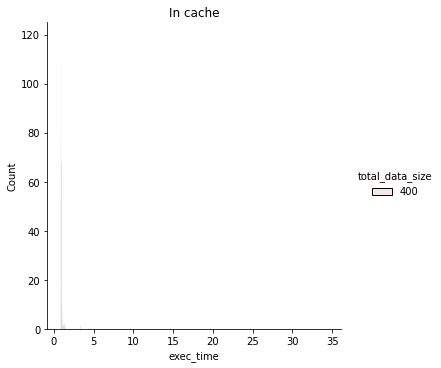

In [29]:
for i in df1_refined['task_class_id'].unique():
    title = 'In cache'
    plt.figure()
    sns.displot(df1_class[i], x="exec_time", hue='total_data_size')
    plt.title(title)
plt.show()

<Figure size 432x288 with 0 Axes>

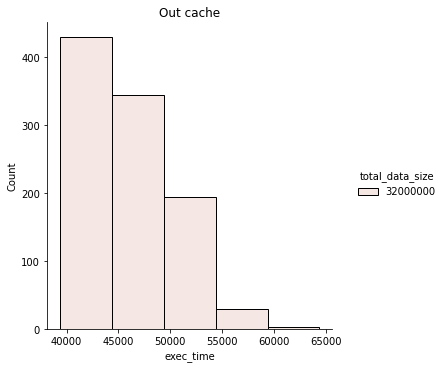

In [26]:
for i in df2_refined['task_class_id'].unique():
    title = 'Out cache'
    plt.figure()
    sns.displot(df2_class[i], x="exec_time", hue='total_data_size', binwidth=5e3)
    plt.title(title)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


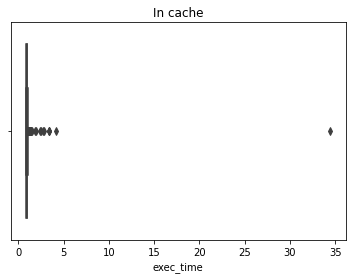

In [27]:
for i in df1_refined['task_class_id'].unique():
    title = 'In cache'
    plt.figure()
    sns.boxplot(df1_class[i]['exec_time'])
    plt.title(title)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


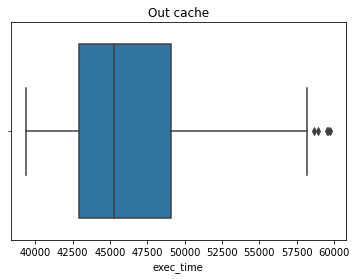

In [28]:
for i in df2_refined['task_class_id'].unique():
    title = 'Out cache'
    plt.figure()
    sns.boxplot(df2_class[i]['exec_time'])
    plt.title(title)
plt.show()